# Kerr Angle Conversions Example Notebook

## Loading the package

First, load in the package using the following command

In [1]:
import os
import sys

# Need to point to where the package is installed
# It will always be in the build directory, but the next folder name might change on your machine
sys.path.append(os.path.abspath('../build/lib.macosx-11.0-arm64-cpython-39'))
import kerrangleconversions as kac

Load in the other packages we will need for this notebook

In [2]:
from time import perf_counter
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Example Conversion

First, we assign the orbital elements of the geodesic orbit

In [3]:
a = 0.9
p = 10
e = 0.3
x = 0.8

Then we assign the values of the phases

In [4]:
psi0 = 1.2
chi0 = 0.5
phi0 = 10

We are going to convert from Quasi-Keplerian or Dawrin Phases to the Boyer-Lindquist action angles

In [5]:
time = perf_counter()
(Phi_r,Phi_theta,Phi_phi) = kac.pyDarwinPhasesToBoyerLindquistPhases(a,p,e,x,psi0,chi0,phi0)
total_time = (perf_counter() - time) *1000
print("Time taken: %.3f ms" % total_time)
(Phi_r,Phi_theta,Phi_phi)

Time taken: 0.104 ms


(0.7656854348230792, -0.0866817374910737, 9.264252315901594)

Now, we are going to take our solution and test the inverse transformation from Boyer-Lindquist actio angles back to Quasi-Keplerian phases

In [6]:
time = perf_counter()
(psi2,chi2,phi2) = kac.pyBoyerLindquistPhasesToDarwinPhases(a,p,e,x,Phi_r,Phi_theta,Phi_phi)
total_time = (perf_counter() - time) *1000
print("Time taken: %.3f ms" % total_time)
(psi2,chi2,phi2)

Time taken: 0.253 ms


(1.1999999999998807, 0.4999999999998478, 9.999999999999941)

Taking the difference between this result and our original angles allows us to estimate the error

In [7]:
(psi0-psi2,chi0-chi2,phi0-phi2)

(1.192379528447418e-13, 1.5221157667610896e-13, 5.861977570020827e-14)

## Trajectory Evolution

We now want to demonstrate how this would work for a geodesic trajectory

In [8]:
# Parameters
a = 0.9
p = 10
e = 0.3
x = 0.8

# Initial Conditions
psi0 = 1.2
chi0 = 0.5
phi0 = 10

We first must define the Quasi-Keplerian Equations of Motion

In [9]:
def Quasi_Keplerian_EoM(t, z):
    [psi, chi, phi] = z  # z is a list or array with [psi, chi,phi]
    dpsidt = kac.pyRadialDarwinFrequency(a,p,e,x,psi,chi)
    dchidt = kac.pyPolarDarwinFrequency(a,p,e,x,psi,chi)
    dphidt = kac.pyAzimuthalDarwinFrequency(a,p,e,x,psi,chi)
    return [dpsidt, dchidt,dphidt]

And now we solve them numerically

In [10]:
# Assign initial conditions
initial_conditions = [psi0,chi0,phi0]

# Time span for the solution
t_span = (0, 2500) 


In [11]:
time = perf_counter()
solution = solve_ivp(Quasi_Keplerian_EoM, t_span, initial_conditions,method='RK45', rtol=1e-13, atol=1e-13)

# Print the time taken
total_time = (perf_counter() - time) *1000
print("Time taken: %.3f ms" % total_time)

# Extract the solution
t = solution.t  # Time points
psi = solution.y[0]  # Solution for x(t)
chi = solution.y[1]  # Solution for y(t)
phi = solution.y[2]

Time taken: 68.803 ms


We can obtain the solution for the Action Angles analytically, which will always be faster and more accurate than doing it numerically

In [12]:
# Assign Frequencies
Omega_r = kac.pyRadialFrequency(a,p,e,x)
Omega_theta = kac.pyPolarFrequency(a,p,e,x)
Omega_phi= kac.pyAzimuthalFrequency(a,p,e,x)

# Assign ICs
(Phi_r0,Phi_theta0,Phi_phi0) = kac.pyDarwinPhasesToBoyerLindquistPhases(a,p,e,x,psi0,chi0,phi0)

time = perf_counter()
# Phase = time * freqeuncy + IC
Phi_r = Omega_r * t + Phi_r0
Phi_theta = Omega_theta * t + Phi_theta0
Phi_phi = Omega_phi * t + Phi_phi0

# Print the time taken
total_time = (perf_counter() - time) *1000
print("Time taken: %.3f ms" % total_time)

Time taken: 0.464 ms


And now we can transform both of these soluions to test their accuracy against each other

In [13]:
psi_from_AA = np.zeros(len(t))
chi_from_AA = np.zeros(len(t))
phi_from_AA = np.zeros(len(t))

time = perf_counter()
for i in range(len(t)):
    (psi_from_AA[i],chi_from_AA[i],phi_from_AA[i] ) = kac.pyBoyerLindquistPhasesToDarwinPhases(a,p,e,x,Phi_r[i],Phi_theta[i],Phi_phi[i])

# Print the time taken
total_time = (perf_counter() - time) *1000
print("Time taken: %.3f ms" % total_time)

Time taken: 228.339 ms


In [14]:
Phi_r_from_QK = np.zeros(len(t))
Phi_theta_from_QK = np.zeros(len(t))
Phi_phi_from_QK = np.zeros(len(t))

time = perf_counter()
for i in range(len(t)):
    (Phi_r_from_QK[i],Phi_theta_from_QK[i],Phi_phi_from_QK[i] ) = kac.pyDarwinPhasesToBoyerLindquistPhases(a,p,e,x,psi[i],chi[i],phi[i])

# Print the time taken
total_time = (perf_counter() - time) * 1000
print("Time taken: %.3f ms" % total_time )

Time taken: 29.852 ms


As we can see, converting from one to the other can be slow (although this could be sped up with parallelization).

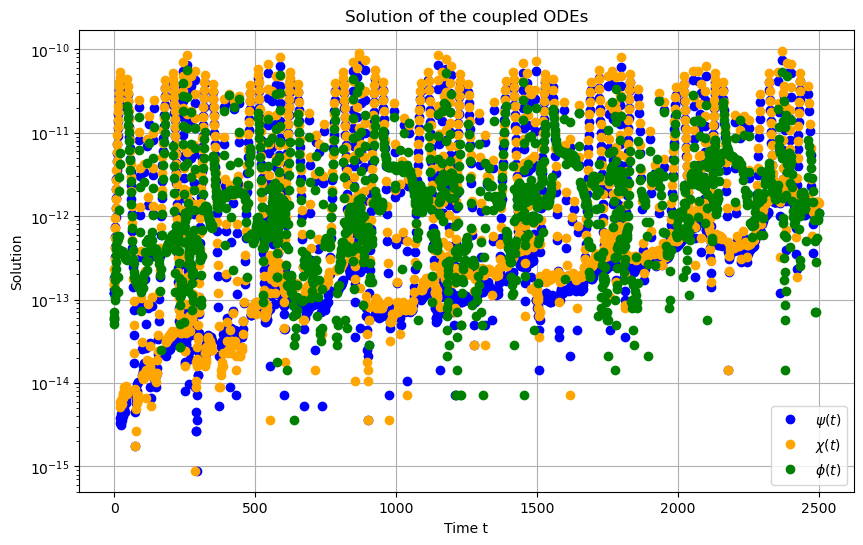

In [15]:
plt.figure(figsize=(10, 6))

# Plot x(t)
plt.yscale('log')
plt.plot(t, abs(psi - psi_from_AA),color='blue',marker= 'o', linestyle= 'none',label='$\psi (t)$')
plt.plot(t, abs(chi - chi_from_AA), color='orange',marker= 'o', linestyle= 'none',label='$\chi (t)$')
plt.plot(t, abs(phi - phi_from_AA), color='green',marker= 'o', linestyle= 'none', label='$\phi (t)$')
# Plot y(t)
#plt.plot(t, Phi_r, label='$\chi (t)$', color='orange')


#plt.plot(t, psi_from_AA, label='$\psi (t)$ from Action Angles', color='red',linestyle='dashed')

# Labels and title
plt.xlabel('Time t')
plt.ylabel('Solution')
plt.title('Solution of the coupled ODEs')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

So we see that the error in the transformation is in line with the tolarance on the root solver of $10^{-10}$

In [16]:
def Radial_Coordinate(p,e,psi):
    return p/(1 + e * np.cos(psi))

def Polar_Coordinate(x,chi):
    return np.arccos(np.sqrt(1 - x * x) * np.cos(chi))

In [17]:
r = Radial_Coordinate(p,e,psi)
theta = Polar_Coordinate(x,chi)

x_coord = r * np.sin(theta) * np.cos(phi)
y_coord = r * np.sin(theta) * np.sin(phi)
z_coord = r * np.cos(theta)

In [18]:
r_from_AA = Radial_Coordinate(p,e,psi_from_AA)
theta_from_AA = Polar_Coordinate(x,chi_from_AA)

x_coord_from_AA = r_from_AA * np.sin(theta_from_AA) * np.cos(phi_from_AA)
y_coord_from_AA = r_from_AA * np.sin(theta_from_AA) * np.sin(phi_from_AA)
z_coord_from_AA = r_from_AA * np.cos(theta_from_AA)

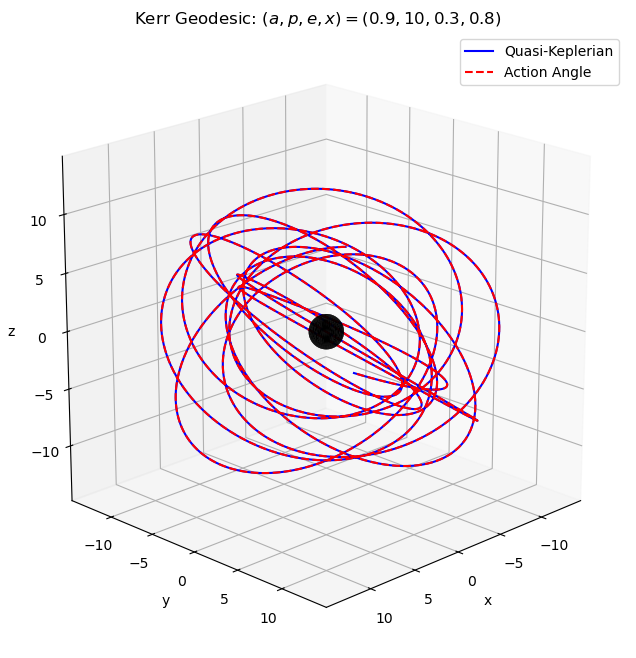

In [31]:

### First, let's create a black hole
# Define the radius of the BH
rBH = 1 + np.sqrt(1 - a*a)

# Create a mesh grid for the spherical coordinates
thetaBH = np.linspace(0,  np.pi, 100)
phiBH = np.linspace(0, 2 * np.pi, 100)
thetaBH, phiBH = np.meshgrid(thetaBH, phiBH)

# Parametric equations for the BH
xBH = rBH * np.sin(thetaBH) * np.cos(phiBH)
yBH = rBH * np.sin(thetaBH) * np.sin(phiBH)
zBH = rBH * np.cos(thetaBH)



# Create a new figure
fig = plt.figure(figsize=(12,8))

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Plot the parametric BH
ax.plot_surface(xBH, yBH, zBH, color='black', edgecolor='none')

# Plot the trajectories
ax.plot(x_coord, y_coord, z_coord, label='Quasi-Keplerian', color='blue')
ax.plot(x_coord, y_coord, z_coord, label='Action Angle', color = 'red', linestyle='dashed')



# Add labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Kerr Geodesic: $(a,p,e,x) = (0.9,10,0.3,0.8)$')

ax.set_xlim([-p/(1 - e), p/(1 - e)])
ax.set_ylim([-p/(1 - e), p/(1 - e)])
ax.set_zlim([-p/(1 - e), p/(1 - e)])

ax.view_init(elev = 20, azim = 45)

ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio for all axes
# Show the legend
ax.legend()

# Display the plot
plt.show()
